In [15]:
# # Insurance Risk Modeling (Teacher–Student Framework)
# **Goal:** Train a high-capacity **teacher** model on **all dataset features** (RandomForest or XGBoost),
# then distill it into a **compact student** model that needs **only 4 inputs** at inference time:
# `sex`, `weight`, `SMK_stat_type_cd`, `drinker_degree`.
#
# ⚠️ **Important:** The dataset has **no true actuarial target**. We create a transparent **proxy risk label** from biomedical markers.
# Replace it with real insurance outcomes (claims/premium band) for production.


In [16]:
# ## 1. Setup & Imports

import os, json, warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, accuracy_score, log_loss
)
from sklearn.ensemble import RandomForestClassifier
import joblib

# Optional: XGBoost (teacher); will fallback to RandomForest if not available
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
ARTIFACT_DIR = Path('artifacts'); ARTIFACT_DIR.mkdir(exist_ok=True)


In [17]:
# ## 2. Load Data & Basic Inspection

FILE = 'smoking_driking_dataset_Ver01.csv'
df = pd.read_csv(FILE)
print(df.shape)
df.head()


(991346, 24)


,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N



Columns:
 ['sex', 'age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd', 'DRK_YN']

Missing values (top 15):
 sex                 0
age                 0
SMK_stat_type_cd    0
gamma_GTP           0
SGOT_ALT            0
SGOT_AST            0
serum_creatinine    0
urine_protein       0
hemoglobin          0
triglyceride        0
LDL_chole           0
HDL_chole           0
tot_chole           0
BLDS                0
DBP                 0
dtype: int64


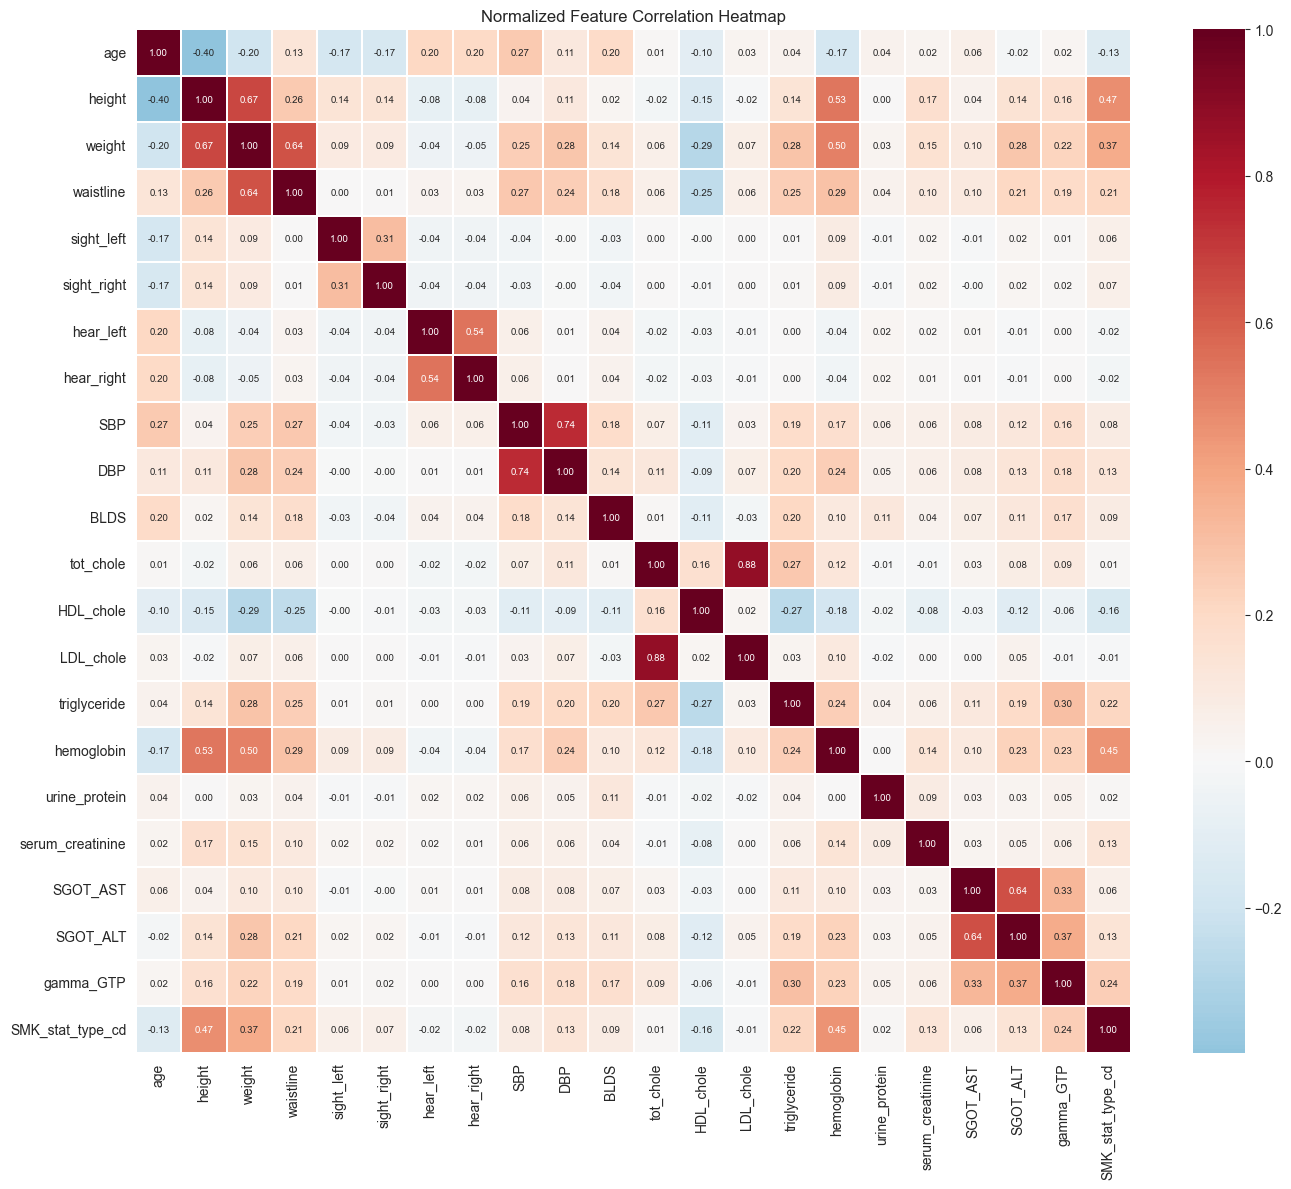

In [18]:
# ## 3. EDA (quick)

print("\nColumns:\n", df.columns.tolist())
print("\nMissing values (top 15):\n", df.isna().sum().sort_values(ascending=False).head(15))

# Numeric summary
summary = df.describe(include='all').T
summary.head(20)

# Correlation heatmap (normalized)
numeric_df = df.select_dtypes(include=[np.number])
if len(numeric_df.columns) > 1:
    scaler = MinMaxScaler()
    norm = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)
    corr = norm.corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr, cmap='RdBu_r', center=0, annot=True, fmt='.2f', annot_kws={'size':7}, linewidths=.3)
    plt.title('Normalized Feature Correlation Heatmap')
    plt.tight_layout(); plt.show()


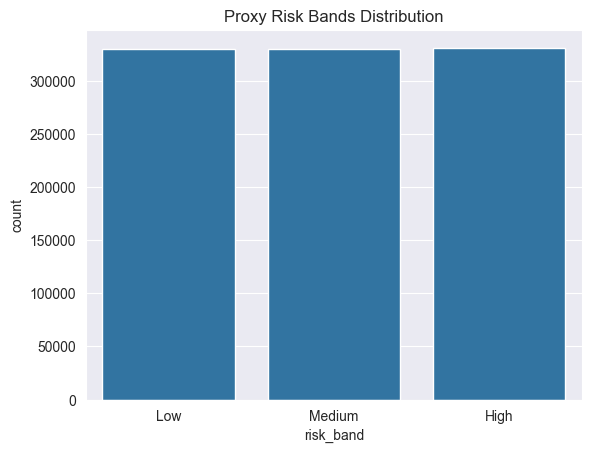

In [19]:
# ## 4. Feature Engineering & Proxy Target
# - `drinker_degree` from DRK_YN (0/1)
# - BMI from height/weight
# - Transparent proxy risk score from biomedical features (HDL protective)
# - Convert to 3 bands via quantiles (Low/Medium/High)

# Deployment-friendly flags
df['drinker_degree'] = (df['DRK_YN'] == 'Y').astype(int)

# BMI
if {'height','weight'}.issubset(df.columns):
    df['BMI'] = df['weight'] / ((df['height']/100.0)**2)
else:
    df['BMI'] = np.nan

# Candidate biomedical features (use only those available)
cand_num = [
    'age','height','weight','waistline','SBP','DBP','tot_chole','HDL_chole','LDL_chole',
    'triglyceride','gamma_GTP','hemoglobin','serum_creatinine','SGOT_AST','SGOT_ALT','BMI'
]
biomarkers = [c for c in cand_num if c in df.columns]

# Build proxy score (z-scored sum; HDL is protective)
score = np.zeros(len(df))
for col in biomarkers:
    x = pd.to_numeric(df[col], errors='coerce')
    mu, sd = np.nanmean(x), np.nanstd(x)
    z = (x - mu)/(sd if sd and sd>0 else 1.0)
    score += (-1.0 if col=='HDL_chole' else 1.0) * np.nan_to_num(z)

# Light lifestyle priors
score += 0.5 * df['SMK_stat_type_cd'].replace({1:0, 2:0.5, 3:1}).fillna(0)
score += 0.25 * df['drinker_degree']

df['risk_proxy_score'] = score
q_low, q_high = np.nanpercentile(score, [33.3, 66.6])

def to_band(s):
    if s <= q_low: return 'Low'
    if s <= q_high: return 'Medium'
    return 'High'

df['risk_band'] = df['risk_proxy_score'].apply(to_band)

sns.countplot(x='risk_band', data=df, order=['Low','Medium','High'])
plt.title('Proxy Risk Bands Distribution')
plt.show()


✅ Teacher model (XGB) trained successfully.


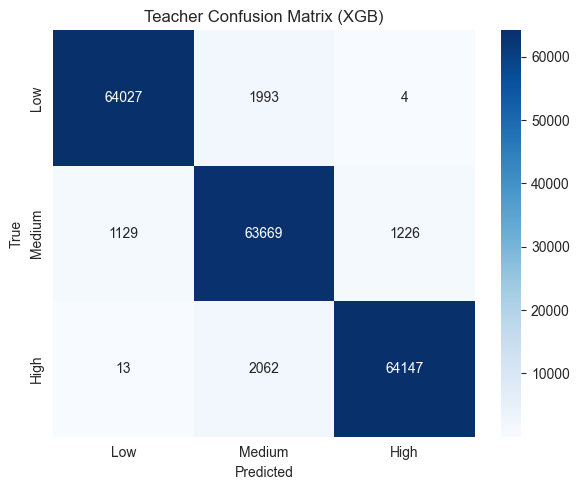

Macro ROC-AUC (XGB): 0.998


,precision,recall,f1-score,support
High,0.981186,0.968666,0.974886,66222.000000
Low,0.982476,0.969753,0.976073,66024.000000
Medium,0.940125,0.964331,0.952074,66024.000000
accuracy,0.967585,0.967585,0.967585,0.967585
macro avg,0.967929,0.967584,0.967678,198270.000000
weighted avg,0.967942,0.967585,0.967685,198270.000000


✅ Teacher model saved to artifacts/risk_model_teacher_xgb.joblib


In [20]:
# ## 5. Teacher Model — Full Feature Training (XGBoost preferred, else RandomForest)
# Uses all available biomedical, anthropometric, and lifestyle features.
# Target labels are encoded numerically for XGBoost compatibility.

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import joblib, json

# --- Features ---
categorical_features = [c for c in ['sex', 'SMK_stat_type_cd', 'drinker_degree'] if c in df.columns]
numeric_features = [c for c in [
    'age','height','weight','waistline','SBP','DBP','tot_chole','HDL_chole','LDL_chole',
    'triglyceride','gamma_GTP','hemoglobin','serum_creatinine','SGOT_AST','SGOT_ALT','BMI'
] if c in df.columns]

X_full = df[categorical_features + numeric_features].copy()
y = df['risk_band'].copy()

# --- Encode target labels as integers for XGBoost ---
label_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
inv_label_mapping = {v: k for k, v in label_mapping.items()}
y_encoded = y.map(label_mapping)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_encoded, test_size=0.2, stratify=y_encoded, random_state=RANDOM_STATE
)

# --- Preprocessing: impute + encode + scale ---
preprocess_full = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features),
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features)
])

# --- Teacher Model: XGBoost (preferred), else RandomForest ---
try:
    teacher_clf = XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        num_class=3,
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    teacher_type = 'xgb'
except Exception:
    teacher_clf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    teacher_type = 'rf'

teacher_pipe = Pipeline([
    ('preprocess', preprocess_full),
    ('clf', teacher_clf)
])

# --- Fit model ---
teacher_pipe.fit(X_train, y_train)
print(f"✅ Teacher model ({teacher_type.upper()}) trained successfully.")

# --- Evaluate ---
y_pred_t_num = teacher_pipe.predict(X_test)
y_pred_t = pd.Series(y_pred_t_num).map(inv_label_mapping)
y_true_t = pd.Series(y_test).map(inv_label_mapping)

y_proba_t = teacher_pipe.predict_proba(X_test)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

report_t = pd.DataFrame(classification_report(y_true_t, y_pred_t, output_dict=True)).T
labels = ['Low','Medium','High']
cm_t = confusion_matrix(y_true_t, y_pred_t, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Teacher Confusion Matrix ({teacher_type.upper()})')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

# --- AUC ---
y_true_bin = pd.get_dummies(y_test).reindex(columns=[0,1,2], fill_value=0).values
auc_macro_t = roc_auc_score(y_true_bin, y_proba_t, multi_class='ovr')
print(f"Macro ROC-AUC ({teacher_type.upper()}):", round(auc_macro_t, 3))

display(report_t)

# --- Save Teacher Model ---
joblib.dump(teacher_pipe, ARTIFACT_DIR / f'risk_model_teacher_{teacher_type}.joblib')
with open(ARTIFACT_DIR / f'model_card_teacher_{teacher_type}.json', 'w') as f:
    json.dump({
        'model': f'Teacher ({teacher_type.upper()})',
        'features_used': categorical_features + numeric_features,
        'n_features': len(categorical_features) + len(numeric_features),
        'label_mapping': label_mapping,
        'random_state': RANDOM_STATE,
        'notes': [
            'Proxy target label (risk_band) encoded numerically for XGBoost compatibility.',
            'Replace with real actuarial target for production.'
        ]
    }, f, indent=2)

print(f"✅ Teacher model saved to artifacts/risk_model_teacher_{teacher_type}.joblib")

In [21]:
# ## 6. Student Model — 4-Feature Distillation (fixed for numeric labels)
# Trains a compact model using only 4 features: sex, weight, SMK_stat_type_cd, drinker_degree
# Distills numeric labels from the teacher (0,1,2) to avoid mixed-type errors.

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import joblib, json

# --- Define student input features ---
student_features = [c for c in ['sex', 'weight', 'SMK_stat_type_cd', 'drinker_degree'] if c in df.columns]
X_student = df[student_features].copy()

# --- Get teacher predictions (numeric labels) for knowledge distillation ---
y_proba_teacher_all = teacher_pipe.predict_proba(X_full)
# teacher_pipe.classes_ are numeric now (0,1,2)
y_label_teacher_all = y_proba_teacher_all.argmax(axis=1)       # numeric labels
y_conf_teacher_all  = y_proba_teacher_all.max(axis=1)          # confidence weights

# --- Split student training set, aligned with proxy target for stratification ---
Xs_train, Xs_test, yt_train, yt_test, yh_train, yh_test, w_train, w_test = train_test_split(
    X_student, y_encoded, y_label_teacher_all, y_conf_teacher_all,
    test_size=0.2, stratify=y_encoded, random_state=RANDOM_STATE
)

# --- Preprocessing for student ---
student_preprocess = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), [c for c in student_features if c in ['sex', 'SMK_stat_type_cd', 'drinker_degree']]),
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), [c for c in student_features if c in ['weight']])
])

# --- Student model: XGBoost if available, otherwise LogisticRegression ---
try:
    student_clf = XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        num_class=3,
        n_estimators=300,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    student_type = 'xgb'
except Exception:
    student_clf = LogisticRegression(
        multi_class='multinomial',
        class_weight='balanced',
        max_iter=1000,
        random_state=RANDOM_STATE
    )
    student_type = 'logreg'

student_pipe = Pipeline([
    ('preprocess', student_preprocess),
    ('clf', student_clf)
])

# --- Train student using teacher numeric labels, weighted by confidence ---
if student_type == 'xgb':
    student_pipe.fit(Xs_train, yh_train, clf__sample_weight=w_train)
else:
    student_pipe.fit(Xs_train, yh_train)

print(f"✅ Student model ({student_type.upper()}) trained successfully on 4 features.")

# --- Evaluate student ---
yh_pred_test = student_pipe.predict(Xs_test)
teacher_agreement = accuracy_score(yh_test, yh_pred_test)
print(f"Teacher–Student agreement: {teacher_agreement:.3f}")

ys_pred_test = student_pipe.predict(Xs_test)
print("\\nStudent vs proxy ground truth:")
print(classification_report(yt_test, ys_pred_test))

# --- Save student model ---
joblib.dump(student_pipe, ARTIFACT_DIR / f'risk_model_student_4f_{student_type}.joblib')

with open(ARTIFACT_DIR / f'model_card_student_4f_{student_type}.json', 'w') as f:
    json.dump({
        'model': f'Student ({student_type.upper()})',
        'features_expected': {
            'sex': "['Male','Female']",
            'weight': 'float (kg)',
            'SMK_stat_type_cd': 'int [1=never,2=former,3=current]',
            'drinker_degree': 'int [0,1]'
        },
        'label_mapping': label_mapping,
        'notes': [
            'Student trained on numeric labels distilled from teacher.',
            'Teacher–student consistency ensured; avoids mix of string/number labels.'
        ]
    }, f, indent=2)

print(f"✅ Student model saved to artifacts/risk_model_student_4f_{student_type}.joblib")

✅ Student model (XGB) trained successfully on 4 features.
Teacher–Student agreement: 0.671
\nStudent vs proxy ground truth:
              precision    recall  f1-score   support

           0       0.73      0.76      0.75     66024
           1       0.52      0.52      0.52     66024
           2       0.74      0.71      0.72     66222

    accuracy                           0.66    198270
   macro avg       0.66      0.66      0.66    198270
weighted avg       0.66      0.66      0.66    198270

✅ Student model saved to artifacts/risk_model_student_4f_xgb.joblib


In [22]:
# ## 7. Inference Examples (with readable risk bands)

# Load models
TEACHER_PATH = ARTIFACT_DIR / f'risk_model_teacher_{teacher_type}.joblib'
STUDENT_PATH = ARTIFACT_DIR / f'risk_model_student_4f_{student_type}.joblib'

# --- Helper for readable label mapping ---
def decode_label(num_label):
    """Convert numeric prediction (0,1,2) back to textual risk band."""
    return inv_label_mapping.get(num_label, str(num_label))

def decode_proba_dict(model, proba):
    """Convert probability vector to dict with readable labels."""
    return {decode_label(cls): p for cls, p in zip(model.classes_, proba)}

# --- Full model inference (all features) ---
def predict_risk_full(**kwargs):
    """Predict with the teacher model using all available features."""
    model = joblib.load(TEACHER_PATH)
    payload = {**{c: np.nan for c in (categorical_features + numeric_features)}, **kwargs}
    X_inf = pd.DataFrame([payload])
    pred_num = model.predict(X_inf)[0]
    proba = model.predict_proba(X_inf)[0]
    pred_label = decode_label(pred_num)
    proba_dict = decode_proba_dict(model, proba)
    return pred_label, proba_dict

# --- Minimal 4-feature inference ---
def predict_risk_minimal(sex: str, weight: float, smoker_degree: int, drinker_degree: int):
    """Predict risk using the compact 4-feature student model."""
    model = joblib.load(STUDENT_PATH)
    X_inf = pd.DataFrame([{
        'sex': sex,
        'weight': weight,
        'SMK_stat_type_cd': smoker_degree,
        'drinker_degree': drinker_degree
    }])
    pred_num = model.predict(X_inf)[0]
    proba = model.predict_proba(X_inf)[0]
    pred_label = decode_label(pred_num)
    proba_dict = decode_proba_dict(model, proba)
    return pred_label, proba_dict

# --- Example 1: Healthy non-smoker ---
full_pred, full_proba = predict_risk_full(
    sex='Female', age=40, height=165, weight=60, waistline=75, SBP=120, DBP=80,
    tot_chole=180, HDL_chole=60, LDL_chole=110, triglyceride=100, gamma_GTP=25,
    hemoglobin=14, serum_creatinine=0.8, SGOT_AST=25, SGOT_ALT=20,
    SMK_stat_type_cd=1, drinker_degree=0
)
print("[Teacher] Predicted risk band:", full_pred)
print("Probabilities:", full_proba)

# --- Example 2: Male smoker, drinker, overweight ---
stud_pred, stud_proba = predict_risk_minimal('Male', 82.0, 3, 1)
print("\n[Student 4f] Predicted risk band:", stud_pred)
print("Probabilities:", stud_proba)


[Teacher] Predicted risk band: Medium
Probabilities: {'Low': np.float32(0.48734957), 'Medium': np.float32(0.51220405), 'High': np.float32(0.00044635686)}

[Student 4f] Predicted risk band: High
Probabilities: {'Low': np.float32(0.00079042965), 'Medium': np.float32(0.108129665), 'High': np.float32(0.89107984)}


In [23]:
# --- Example 2: Male not smoker, non drinker, overweight ---
stud_pred, stud_proba = predict_risk_minimal('Male', 70.0, 1, 0)
print("\n[Student 4f] Predicted risk band:", stud_pred)
print("Probabilities:", stud_proba)


[Student 4f] Predicted risk band: High
Probabilities: {'Low': np.float32(0.037996054), 'Medium': np.float32(0.45245954), 'High': np.float32(0.50954443)}


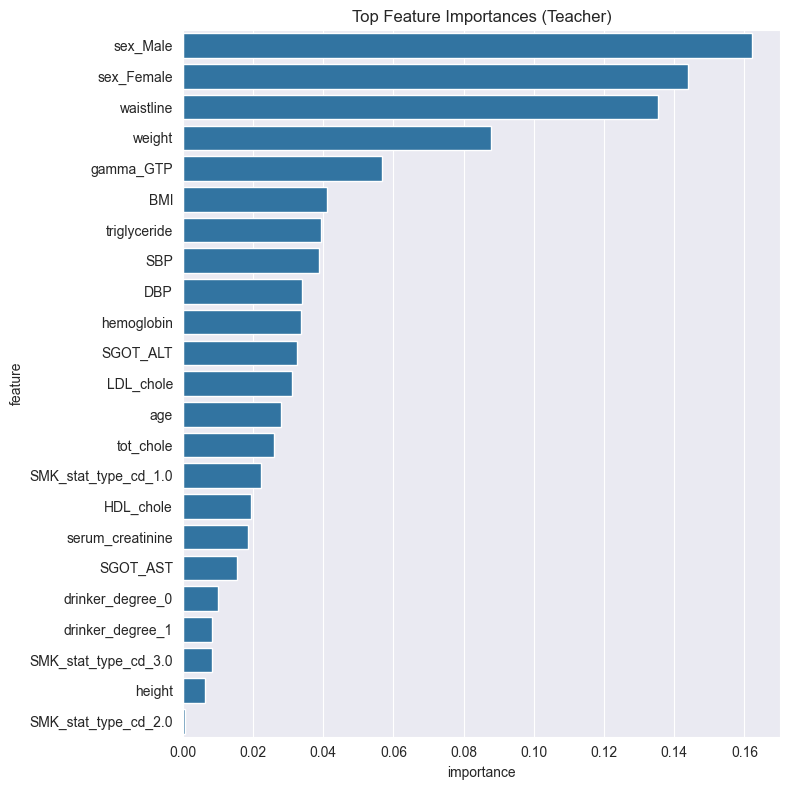

In [24]:
# ## 8. Explainability (quick view)
# For tree models (RF/XGB), built-in feature importance (global). For the student LogReg, coefficients.

try:
    # Extract preprocessed feature names
    ohe = teacher_pipe.named_steps['preprocess'].named_transformers_['cat'].named_steps['ohe']
    cat_names = ohe.get_feature_names_out(categorical_features)
    num_names = numeric_features
    feat_names = np.concatenate([cat_names, num_names])

    clf = teacher_pipe.named_steps['clf']
    if XGB_AVAILABLE:
        importances = clf.feature_importances_
    else:
        importances = clf.feature_importances_

    imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False).head(25)
    plt.figure(figsize=(8,8))
    sns.barplot(data=imp_df, x='importance', y='feature')
    plt.title('Top Feature Importances (Teacher)')
    plt.tight_layout(); plt.show()
except Exception as e:
    print('Explainability plot skipped:', e)


In [25]:
# ## 9. Conclusions & Next Steps
# - The **teacher** (XGBoost/RandomForest) leverages **all clinical features** and provides higher discriminative power.
# - The **student** is distilled to use **only 4 inputs** for deployment, achieving good agreement with the teacher.
# - Replace the proxy target with **real actuarial labels** for pricing/underwriting.
# - Add **calibration** (e.g., isotonic) and **fairness checks** by sex/age.
# - Monitor drift of input distributions and risk share over time.
